In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import tqdm
import pdb
from scipy.sparse import csr_matrix, linalg
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import warnings

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
#import lightgbm as lgb

import random
import os
import re

import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler

from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor

from sklearn.metrics import mean_absolute_error

warnings.filterwarnings(action='ignore')

In [53]:
path= '../data/'

users = pd.read_csv(path+'users.csv')
books = pd.read_csv(path+'books.csv')
train_ratings = pd.read_csv(path+'train_ratings.csv')
test_ratings = pd.read_csv(path+'test_ratings.csv')
submit = pd.read_csv(path + 'sample_submission.csv')


def rmse(real: list, predict: list) -> float:
    pred = np.array(predict)
    return np.sqrt(np.mean((real-pred) ** 2))

SEED = 42
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

seed_everything(SEED)

print('users shape: ', users.shape)
print('books shape: ', books.shape)
print('train_ratings shape: ', train_ratings.shape)

users shape:  (68092, 3)
books shape:  (149570, 10)
train_ratings shape:  (306795, 3)


# 데이터 전처리

## book 테이블

In [55]:
# books 테이블 전처리 부분 입니다.
# books의 이미지 변수를 지워줍니다.
# 제목과 요약 내용 변수를 지웁니다. 
# (이 변수들은 추후 사용 가능할수도 있으나 일단 지웁니다.)
# books의 publisher 변수 중 이름이 비슷한 변수들을 찾아 하나로 통일해줍니다.
books.drop(['book_title', 'summary', 'img_url', 'img_path'], axis = 1, inplace = True)

books_publishers = books.groupby('publisher')['isbn'].count().sort_values(ascending=False)
for i in books_publishers[books_publishers > 20].index: # 20 말고 10으로 하면 오류가 남..
    books['publisher'][books['publisher'].str.contains(i)] = i

In [56]:
# books의 카테고리 부분.

# 대괄호 써있는 카테고리 전치리
books.loc[books[books['category'].notnull()].index, 'category'] = books[books['category'].notnull()]['category'].apply(lambda x: re.sub('[\W_]+',' ',x).strip())
# 모두 소문자로 통일
books['category'] = books['category'].str.lower()

# 수작업으로 higt 카테고리로 통합
categories = ['garden','crafts','physics','adventure','music','fiction','nonfiction','science','science fiction','social','homicide',
 'sociology','disease','religion','christian','philosophy','psycholog','mathemat','agricult','environmental',
 'business','poetry','drama','literary','travel','motion picture','children','cook','literature','electronic',
 'humor','animal','bird','photograph','computer','house','ecology','family','architect','camp','criminal','language','india']

books['category_high'] = books['category'].copy()
for category in categories:
    books.loc[books[books['category'].str.contains(category,na=False)].index,'category_high'] = category

In [57]:
# language와 category_high NULL 값을 최빈값으로 채웁니다.
# 근거 : language == en일 때, category_high == fiction 일 때와
# 근거 : 값이 NULL 일 때 rating 평균이 7.0x로 유사한 형태.
books['language'].fillna('en', inplace = True)
books['category_high'].fillna('fiction', inplace = True)

In [58]:
# 출판연도 1970, 1980, 1990, 2000, 2020 으로 범주화 시킵니다.
# 딥러닝 과정에서 범주화 시키는 것이 유리합니다.
# 근거 : develop 파일에서 여러번 실험 결과 본 기준이 가장 rating을 잘 구분함.

books['years'] = books['year_of_publication'].copy()
books['years'][books['year_of_publication'] < 1970] = 1970
books['years'][(books['year_of_publication'] < 1980) * (books['year_of_publication'] >= 1970)] = 1980
books['years'][(books['year_of_publication'] < 1990) * (books['year_of_publication'] >= 1980)] = 1990
books['years'][(books['year_of_publication'] < 2000) * (books['year_of_publication'] >= 1990)] = 2000
books['years'][(books['year_of_publication'] >= 2000)] = 2020
books['years'] = books['years'].astype('str')
#books['years'] = books['years'].astype('int')
books.drop(['year_of_publication', 'category'], axis = 1, inplace = True)

## user 테이블

In [59]:
# users 테이블 전처리 입니다.
# location이 지역, 주, 국가로 되어있어 이 부분 기초 전처리 진행 과정입니다.

users['location'] = users['location'].str.replace(r'[^0-9a-zA-Z:,]', '') # 특수문자 제거

# 지역, 주, 국가
users['location_city'] = users['location'].apply(lambda x: x.split(',')[0].strip())
users['location_state'] = users['location'].apply(lambda x: x.split(',')[1].strip())
users['location_country'] = users['location'].apply(lambda x: x.split(',')[2].strip())

users = users.replace('na', np.nan) #특수문자 제거로 n/a가 na로 바뀌게 되었습니다. 따라서 이를 컴퓨터가 인식할 수 있는 결측값으로 변환합니다.
users = users.replace('', np.nan) # 일부 경우 , , ,으로 입력된 경우가 있었으므로 이런 경우에도 결측값으로 변환합니다.

# 도시는 존재하는데 나라 정보가 없는 경우 채워주는 코드
modify_location = users[(users['location_country'].isna())&(users['location_city'].notnull())]['location_city'].values
location = users[(users['location'].str.contains('seattle'))&(users['location_country'].notnull())]['location'].value_counts().index[0]

location_list = []
for location in modify_location:
    try:
        right_location = users[(users['location'].str.contains(location))&(users['location_country'].notnull())]['location'].value_counts().index[0]
        location_list.append(right_location)
    except:
        pass

for location in location_list:
    users.loc[users[users['location_city']==location.split(',')[0]].index,'location_state'] = location.split(',')[1]
    users.loc[users[users['location_city']==location.split(',')[0]].index,'location_country'] = location.split(',')[2]

In [60]:
# 저는 도시, 주, 국가 중 주를 선택했습니다.
# 우선 모든 변수를 다 쓰는 건 아니라고 생각했어요. 도시 < 주 < 국가로 포함관계가 있기 때문이죠.
# 데이터 분석 결과 주와 국가 단위가 비슷한 경우가 많은 것을 확인했습니다.
# 조그만 섬 국가 < 미국 켈리포니아 주 < 미국 같은 경우죠.
# 미국 같은 경우 미국으로 뭉뚱그리기 보다 주 단위로 나누는 것이 맞다고 판단했습니다.
# 실제 미국 주 별로 rating 차이가 꽤 존재합니다.
# 다만 도시 기준으로 나누면 너무 세분화 될 것 같다는 생각이 들었습니다.
# 결론적으로 주를 지역을 나타내는 변수로 사용하기로 하고 결측값을 도시, 나라에서 채우기로 했습니다.

def _fillna(x):
    if pd.isna(x['location_country']):
        # 만약 나라가 기록 안되있는 경우        
        if pd.isna(x['location_city']):
            # 도시까지 없다면 모든 정보가 없음. 최빈값 california 사용.
            return 'california'
        else:
            tem = users['location_state'][users['location_city'] == x['location_city']].value_counts()
            if len(tem) == 0: 
                # 만약 주 이름이 없는 도시이면 도시 이름을 주 이름으로 사용.
                return x['location_city'] 
            else:
                # 그 도시에서 가장 자주 쓰이는 주 이름 사용.
                return tem.index[0]

    else:
        tem = users['location_state'][users['location_country'] == x['location_country']].value_counts()
        if len(tem) == 0: 
            # 만약 주 이름이 없는 나라이면 나라이름을 주 이름으로 사용.
            return x['location_country'] 
        else:
            # 그 나라에서 가장 자주 쓰이는 주 이름 사용.
            return tem.index[0]

users['fix_location_state'] = users.apply(lambda x : _fillna(x) if pd.isna(x['location_state']) else x['location_state'], axis = 1)

In [61]:
users['fix_age'] = users['age'].copy()
users['fix_age'][users['age'] < 10] = 10
users['fix_age'][(users['age'] < 20) & (users['age'] >= 10)] = 20
users['fix_age'][(users['age'] < 30) & (users['age'] >= 20)] = 30
users['fix_age'][(users['age'] < 35) & (users['age'] >= 30)] = 35
users['fix_age'][(users['age'] < 40) & (users['age'] >= 35)] = 40
users['fix_age'][(users['age'] < 50) & (users['age'] >= 40)] = 50
users['fix_age'][users['age'] >= 50] = 100
users['fix_age'].fillna(10, inplace = True)
users['fix_age'] = users['fix_age'].astype('str') # users['fix_age'] = users['fix_age'].astype('int')

In [38]:
# users2 = pd.read_csv(path+'users.csv')
# users['age'] = users2['age']

In [41]:
# def age_map(x: int) -> int:
#     x = int(x)
#     if x < 20:
#         return 1
#     elif x >= 20 and x < 30:
#         return 2
#     elif x >= 30 and x < 40:
#         return 3
#     elif x >= 40 and x < 50:
#         return 4
#     elif x >= 50 and x < 60:
#         return 5
#     else:
#         return 6

# users['age'] = users['age'].fillna(users['age'].mean())
# users['age'] = users['age'].apply(age_map)

# users['age'].value_counts()

3    38657
2    10969
4     6858
5     4960
1     4050
6     2598
Name: age, dtype: int64

In [62]:
users = users[['user_id', 'fix_location_state', 'fix_age']]
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68092 entries, 0 to 68091
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   user_id             68092 non-null  int64 
 1   fix_location_state  68092 non-null  object
 2   fix_age             68092 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.6+ MB


## rating 테이블과 merge

In [63]:
# 전처리 완료한 books와 users 테이블을 이용해 rating 테이블과 merge 하기.

train_ratings = pd.merge(train_ratings,books, how='right',on='isbn')
train_ratings.dropna(subset=['rating'], inplace = True)
train_ratings = pd.merge(train_ratings, users, how='right',on='user_id')
train_ratings.dropna(subset=['rating'], inplace = True)

test_ratings['index'] = test_ratings.index
test_ratings = pd.merge(test_ratings,books, how='right',on='isbn')
test_ratings.dropna(subset=['rating'], inplace = True)
test_ratings = pd.merge(test_ratings, users, how='right',on='user_id')
test_ratings.dropna(subset=['rating'], inplace = True)
test_ratings = test_ratings.sort_values('index')
test_ratings.drop(['index'], axis=1, inplace=True)

train_ratings['user_id'] = train_ratings['user_id'].astype('str')
test_ratings['user_id'] = test_ratings['user_id'].astype('str')


# 모델링

In [64]:
# params_cat = {
#             "task_type" : "GPU",
#             "devices" : '0',
#             "random_state": SEED,
#             "learning_rate": 0.05,
#             "n_estimators": 2000,
#             "verbose" : 1,
#             "objective" : "RMSE",
#             "max_depth": 10,#trial.suggest_int("max_depth", 1, 16),
#             "colsample_bylevel": 1,#trial.suggest_float("colsample_bylevel", 0.8, 1.0),
#             #"subsample": 0.8, #trial.suggest_float("subsample", 0.3, 1.0), GPU 사용시 안될수도.
#             "min_child_samples": 50, #trial.suggest_int("min_child_samples", 5, 100),
#             "max_bin": 300, #trial.suggest_int("max_bin", 200, 500),
#             "cat_features" : list(train_ratings.drop(['rating'],axis = 1).columns)
#     }

params_cat = {
    "task_type" : "GPU",
    "devices" : '0',
    "random_state": SEED,
    'learning_rate': 0.04574578205475402, 
    'bagging_temperature': 0.12172958098369972, 
    'n_estimators': 8459, 
    'max_depth': 8, 
    'random_strength': 28, 
    'l2_leaf_reg': 1.6285455533915874e-05, 
    'min_child_samples': 18, 
    'max_bin': 441, 
    'od_type': 'Iter',
    "cat_features" : list(train_ratings.drop(['rating'],axis = 1).columns),
}

X_tr, X_val, y_tr, y_val = train_test_split(train_ratings.drop(['rating'],axis = 1), train_ratings['rating'], test_size=0.2)

model = CatBoostRegressor(**params_cat)
model.fit(
    X_tr,
    y_tr,
    eval_set=[(X_val, y_val)],
    #early_stopping_rounds=10,
    verbose=False,
)

cat_pred = model.predict(X_val)
log_score = rmse(y_val, cat_pred)

print(log_score)

2.141027794444738


In [66]:
X_val['cat_pred'] = cat_pred
X_val['y'] = y_val

In [68]:
X_tr

,user_id,isbn,book_author,publisher,language,category_high,years,fix_location_state,fix_age
121471,18082.0,0671027646,Richard Paul Evans,Pocket,en,fiction,2000.0,california,40.0
267856,135409.0,0972380698,Marie Watts,Turnkey Press,en,fiction,2020.0,texas,50.0
60304,171118.0,015694877X,T. S. Eliot,Harvest Books,en,poetry,1970.0,ontario,50.0
111358,98391.0,0425186377,Stephen J. Clark,Berkley Publishing Group,en,fiction,2020.0,georgia,100.0
314119,223232.0,1578563852,LINDA ANDERSEN,WaterBrook Press,en,religion,2020.0,michigan,100.0
...,...,...,...,...,...,...,...,...,...
120033,51883.0,0786015772,Steve Jackson,Pinnacle Books,en,social,2020.0,missouri,35.0
261557,11456.0,0515126098,Dick Francis,Jove Books,en,detective and mystery stories,2000.0,kentucky,10.0
132118,101336.0,0130952842,Edward Yourdon,Prentice Hall,en,software maintenance,2000.0,florida,50.0
147110,21370.0,0140082255,Linda Tschirhart Sanford,Penguin,en,fiction,1990.0,tennessee,40.0


In [70]:
X_tr[['user_id', 'isbn']].to_csv(path+'ksy_train.csv', index = False)

X_val[['user_id', 'isbn', 'cat_pred', 'y']].to_csv(path+'ksy_valid.csv', index = False)

In [51]:
X_val.to_csv(path+'ksy_valid.csv', index = False)

In [46]:
y_val

31346      9.0
114336     2.0
310060    10.0
283542     2.0
19105      8.0
          ... 
89277      7.0
8961       8.0
2188       1.0
93433      9.0
2856       7.0
Name: rating, Length: 61359, dtype: float64

In [36]:
def objective(trial):
    param = {
        "random_state":42,
        "objective" : "RMSE",
        'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.5),
        'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),
        "n_estimators":trial.suggest_int("n_estimators", 1000, 10000),
        "max_depth":trial.suggest_int("max_depth", 4, 16),
        'random_strength' :trial.suggest_int('random_strength', 0, 100),
    #   "colsample_bylevel":trial.suggest_float("colsample_bylevel", 0.4, 1.0), 이거 때메 GPU 안돌아감
        "l2_leaf_reg":trial.suggest_float("l2_leaf_reg",1e-8,3e-5),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "max_bin": trial.suggest_int("max_bin", 200, 500),
        'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
    }
    train_x, val_x, train_y, val_y = train_test_split(train_ratings.drop(['rating'],axis = 1), train_ratings['rating'], test_size=0.2)

    model = CatBoostRegressor(**param, task_type = 'GPU')

    model.fit(
        train_x,
        train_y,
        eval_set=[(val_x, val_y)],
        cat_features = list(train_ratings.drop(['rating'],axis = 1).columns),
        verbose=100
    )

    cat_pred = model.predict(val_x)
    log_score = rmse(val_y, cat_pred)

    return log_score

In [37]:
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(
    study_name = 'cat_parameter_opt',
    direction = 'minimize',
    sampler = sampler,
)
study.optimize(objective, n_trials=10)
print("Best Score:",study.best_value)
print("Best trial",study.best_trial.params)

[I 2022-10-31 06:52:02,076] A new study created in memory with name: cat_parameter_opt


0:	learn: 2.4299163	test: 2.4436516	best: 2.4436516 (0)	total: 12.2ms	remaining: 1m 32s
100:	learn: 2.4241328	test: 2.4367401	best: 2.4367401 (100)	total: 1.1s	remaining: 1m 21s
200:	learn: 2.4241323	test: 2.4367285	best: 2.4367283 (195)	total: 2.13s	remaining: 1m 18s
bestTest = 2.436728266
bestIteration = 195
Shrink model to first 196 iterations.


[I 2022-10-31 06:52:07,008] Trial 0 finished with value: 2.436728570644674 and parameters: {'learning_rate': 0.043284502212938815, 'bagging_temperature': 63.512210106407046, 'n_estimators': 7588, 'max_depth': 11, 'random_strength': 15, 'l2_leaf_reg': 4.688275664882717e-06, 'min_child_samples': 10, 'max_bin': 460, 'od_type': 'Iter'}. Best is trial 0 with value: 2.436728570644674.


0:	learn: 2.4371201	test: 2.4168686	best: 2.4168686 (0)	total: 11.5ms	remaining: 1m 38s
100:	learn: 2.4318873	test: 2.4108430	best: 2.4108430 (100)	total: 1.09s	remaining: 1m 30s
200:	learn: 2.4312950	test: 2.4100490	best: 2.4100490 (200)	total: 2.12s	remaining: 1m 27s
300:	learn: 2.4312282	test: 2.4099218	best: 2.4099218 (300)	total: 3.15s	remaining: 1m 25s
400:	learn: 2.4312206	test: 2.4098947	best: 2.4098947 (399)	total: 4.17s	remaining: 1m 24s
500:	learn: 2.4312196	test: 2.4098874	best: 2.4098873 (498)	total: 5.19s	remaining: 1m 22s
600:	learn: 2.4312198	test: 2.4098851	best: 2.4098851 (600)	total: 6.21s	remaining: 1m 21s
700:	learn: 2.4312198	test: 2.4098845	best: 2.4098843 (677)	total: 7.36s	remaining: 1m 21s
800:	learn: 2.4312197	test: 2.4098842	best: 2.4098841 (749)	total: 8.44s	remaining: 1m 21s
900:	learn: 2.4312197	test: 2.4098842	best: 2.4098841 (749)	total: 9.53s	remaining: 1m 20s
1000:	learn: 2.4312197	test: 2.4098842	best: 2.4098841 (749)	total: 10.6s	remaining: 1m 19s
1

[I 2022-10-31 06:53:37,674] Trial 1 finished with value: 2.4098842347953213 and parameters: {'learning_rate': 0.01083858126934475, 'bagging_temperature': 75.7947995334801, 'n_estimators': 8492, 'max_depth': 6, 'random_strength': 18, 'l2_leaf_reg': 5.51030125050448e-06, 'min_child_samples': 34, 'max_bin': 357, 'od_type': 'IncToDec'}. Best is trial 1 with value: 2.4098842347953213.


0:	learn: 2.4032016	test: 2.3994301	best: 2.3994301 (0)	total: 24ms	remaining: 1m 26s
100:	learn: 2.1866128	test: 2.1590962	best: 2.1590962 (100)	total: 2.29s	remaining: 1m 20s
200:	learn: 2.1655923	test: 2.1524100	best: 2.1524063 (199)	total: 4.38s	remaining: 1m 14s
300:	learn: 2.1489794	test: 2.1501780	best: 2.1501333 (299)	total: 6.42s	remaining: 1m 10s
400:	learn: 2.1353622	test: 2.1496276	best: 2.1496099 (395)	total: 8.5s	remaining: 1m 8s
500:	learn: 2.1230593	test: 2.1490664	best: 2.1490596 (499)	total: 10.5s	remaining: 1m 5s
600:	learn: 2.1126525	test: 2.1489714	best: 2.1484382 (557)	total: 12.6s	remaining: 1m 3s
700:	learn: 2.1020280	test: 2.1488732	best: 2.1484382 (557)	total: 14.7s	remaining: 1m 1s
800:	learn: 2.0922564	test: 2.1488451	best: 2.1484382 (557)	total: 16.9s	remaining: 59.5s
900:	learn: 2.0823179	test: 2.1490355	best: 2.1484382 (557)	total: 19s	remaining: 57.5s
1000:	learn: 2.0723083	test: 2.1494827	best: 2.1484382 (557)	total: 21.1s	remaining: 55.4s
1100:	learn: 

[I 2022-10-31 06:54:58,119] Trial 2 finished with value: 2.1484382507709117 and parameters: {'learning_rate': 0.10952662748632554, 'bagging_temperature': 0.03613894271216528, 'n_estimators': 3629, 'max_depth': 8, 'random_strength': 46, 'l2_leaf_reg': 2.355742708217648e-05, 'min_child_samples': 24, 'max_bin': 354, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.1484382507709117.


0:	learn: 2.3980752	test: 2.3969462	best: 2.3969462 (0)	total: 449ms	remaining: 11m 51s
100:	learn: 2.0410441	test: 2.1582968	best: 2.1582656 (99)	total: 44.2s	remaining: 10m 48s
200:	learn: 1.7228577	test: 2.1743537	best: 2.1582656 (99)	total: 1m 28s	remaining: 10m 11s
300:	learn: 1.3727758	test: 2.2054256	best: 2.1582656 (99)	total: 2m 14s	remaining: 9m 32s
400:	learn: 1.1330356	test: 2.2282211	best: 2.1582656 (99)	total: 2m 59s	remaining: 8m 50s
500:	learn: 0.9555684	test: 2.2413233	best: 2.1582656 (99)	total: 3m 44s	remaining: 8m 6s
600:	learn: 0.8218940	test: 2.2526077	best: 2.1582656 (99)	total: 4m 29s	remaining: 7m 21s
700:	learn: 0.7230621	test: 2.2606388	best: 2.1582656 (99)	total: 5m 14s	remaining: 6m 37s
800:	learn: 0.6353900	test: 2.2668833	best: 2.1582656 (99)	total: 5m 59s	remaining: 5m 52s
900:	learn: 0.5620606	test: 2.2721376	best: 2.1582656 (99)	total: 6m 45s	remaining: 5m 7s
1000:	learn: 0.4979032	test: 2.2766698	best: 2.1582656 (99)	total: 7m 30s	remaining: 4m 22s
11

[I 2022-10-31 07:06:55,919] Trial 3 finished with value: 2.1582656509395948 and parameters: {'learning_rate': 0.10769622478263129, 'bagging_temperature': 0.04809461967501574, 'n_estimators': 1585, 'max_depth': 16, 'random_strength': 97, 'l2_leaf_reg': 2.425383647001267e-05, 'min_child_samples': 34, 'max_bin': 229, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.1484382507709117.


0:	learn: 2.4254027	test: 2.4377824	best: 2.4377824 (0)	total: 239ms	remaining: 5m 12s
100:	learn: 2.2052319	test: 2.2068377	best: 2.2068377 (100)	total: 24s	remaining: 4m 46s
200:	learn: 2.1481846	test: 2.1674578	best: 2.1674578 (200)	total: 47.9s	remaining: 4m 24s
300:	learn: 2.1171201	test: 2.1570493	best: 2.1570493 (300)	total: 1m 12s	remaining: 4m 2s
400:	learn: 2.0913372	test: 2.1527164	best: 2.1527164 (400)	total: 1m 36s	remaining: 3m 38s
500:	learn: 2.0635245	test: 2.1498113	best: 2.1498113 (500)	total: 2m 1s	remaining: 3m 15s
600:	learn: 2.0417858	test: 2.1482712	best: 2.1482712 (600)	total: 2m 25s	remaining: 2m 51s
700:	learn: 2.0167233	test: 2.1471554	best: 2.1471554 (700)	total: 2m 50s	remaining: 2m 27s
800:	learn: 1.9887362	test: 2.1462491	best: 2.1462313 (798)	total: 3m 14s	remaining: 2m 3s
900:	learn: 1.9547306	test: 2.1458039	best: 2.1458013 (882)	total: 3m 38s	remaining: 1m 38s
1000:	learn: 1.9108126	test: 2.1461154	best: 2.1457226 (952)	total: 4m 2s	remaining: 1m 14s


[I 2022-10-31 07:12:20,104] Trial 4 finished with value: 2.145722487694836 and parameters: {'learning_rate': 0.016119044727609194, 'bagging_temperature': 0.9565499215943827, 'n_estimators': 1309, 'max_depth': 15, 'random_strength': 26, 'l2_leaf_reg': 1.987904330777592e-05, 'min_child_samples': 34, 'max_bin': 356, 'od_type': 'IncToDec'}. Best is trial 4 with value: 2.145722487694836.


0:	learn: 2.3818199	test: 2.3998469	best: 2.3998469 (0)	total: 265ms	remaining: 41m 43s
bestTest = 2.299899188
bestIteration = 21
Shrink model to first 22 iterations.


[I 2022-10-31 07:12:32,532] Trial 5 finished with value: 2.2998992793618434 and parameters: {'learning_rate': 0.4439102767051397, 'bagging_temperature': 12.60466458564947, 'n_estimators': 9456, 'max_depth': 15, 'random_strength': 60, 'l2_leaf_reg': 2.7657008308343274e-05, 'min_child_samples': 13, 'max_bin': 258, 'od_type': 'Iter'}. Best is trial 4 with value: 2.145722487694836.


0:	learn: 2.4187281	test: 2.4249871	best: 2.4249871 (0)	total: 24.3ms	remaining: 3m 25s
100:	learn: 2.2032605	test: 2.1662743	best: 2.1662743 (100)	total: 2.23s	remaining: 3m 4s
200:	learn: 2.1916086	test: 2.1565030	best: 2.1565030 (200)	total: 4.51s	remaining: 3m 5s
300:	learn: 2.1843973	test: 2.1532900	best: 2.1532900 (300)	total: 6.79s	remaining: 3m 4s
400:	learn: 2.1743721	test: 2.1497784	best: 2.1497784 (400)	total: 8.8s	remaining: 2m 56s
500:	learn: 2.1657125	test: 2.1476126	best: 2.1476062 (499)	total: 10.8s	remaining: 2m 51s
600:	learn: 2.1581979	test: 2.1463094	best: 2.1463094 (600)	total: 12.8s	remaining: 2m 47s
700:	learn: 2.1514206	test: 2.1455678	best: 2.1455436 (697)	total: 14.8s	remaining: 2m 43s
bestTest = 2.145091959
bestIteration = 771
Shrink model to first 772 iterations.


[I 2022-10-31 07:12:52,668] Trial 6 finished with value: 2.1450919437183678 and parameters: {'learning_rate': 0.04574578205475402, 'bagging_temperature': 0.12172958098369972, 'n_estimators': 8459, 'max_depth': 8, 'random_strength': 28, 'l2_leaf_reg': 1.6285455533915874e-05, 'min_child_samples': 18, 'max_bin': 441, 'od_type': 'Iter'}. Best is trial 6 with value: 2.1450919437183678.


0:	learn: 2.3781804	test: 2.3594666	best: 2.3594666 (0)	total: 134ms	remaining: 2m 20s
100:	learn: 1.8928360	test: 2.1676795	best: 2.1518258 (62)	total: 13.7s	remaining: 2m 8s
200:	learn: 1.4978165	test: 2.2176742	best: 2.1518258 (62)	total: 27.1s	remaining: 1m 54s
300:	learn: 1.2166578	test: 2.2536540	best: 2.1518258 (62)	total: 40.8s	remaining: 1m 41s
400:	learn: 1.0224806	test: 2.2769944	best: 2.1518258 (62)	total: 54.4s	remaining: 1m 27s
500:	learn: 0.8685584	test: 2.2948327	best: 2.1518258 (62)	total: 1m 7s	remaining: 1m 14s
600:	learn: 0.7403358	test: 2.3075726	best: 2.1518258 (62)	total: 1m 21s	remaining: 1m
700:	learn: 0.6475227	test: 2.3161157	best: 2.1518258 (62)	total: 1m 34s	remaining: 47s
800:	learn: 0.5625975	test: 2.3240147	best: 2.1518258 (62)	total: 1m 48s	remaining: 33.5s
900:	learn: 0.4947697	test: 2.3294457	best: 2.1518258 (62)	total: 2m 1s	remaining: 20s
1000:	learn: 0.4369528	test: 2.3338170	best: 2.1518258 (62)	total: 2m 14s	remaining: 6.47s
1048:	learn: 0.413961

[I 2022-10-31 07:15:17,232] Trial 7 finished with value: 2.151825733495834 and parameters: {'learning_rate': 0.20512599422151362, 'bagging_temperature': 0.06235377135673159, 'n_estimators': 1049, 'max_depth': 14, 'random_strength': 71, 'l2_leaf_reg': 2.187292496954921e-05, 'min_child_samples': 79, 'max_bin': 222, 'od_type': 'IncToDec'}. Best is trial 6 with value: 2.1450919437183678.


0:	learn: 2.3705635	test: 2.3667270	best: 2.3667270 (0)	total: 11.3ms	remaining: 45.1s
100:	learn: 2.2041611	test: 2.1673184	best: 2.1672987 (99)	total: 1.27s	remaining: 48.7s
200:	learn: 2.1994718	test: 2.1653153	best: 2.1653074 (199)	total: 2.5s	remaining: 46.9s
300:	learn: 2.1953848	test: 2.1639017	best: 2.1637995 (293)	total: 3.73s	remaining: 45.5s
400:	learn: 2.1924654	test: 2.1630872	best: 2.1630872 (400)	total: 4.95s	remaining: 44.2s
500:	learn: 2.1893333	test: 2.1618568	best: 2.1618415 (498)	total: 6.22s	remaining: 43.2s
600:	learn: 2.1865830	test: 2.1613065	best: 2.1612617 (594)	total: 7.46s	remaining: 41.9s
700:	learn: 2.1842099	test: 2.1606597	best: 2.1606597 (700)	total: 8.69s	remaining: 40.6s
800:	learn: 2.1821936	test: 2.1602780	best: 2.1601598 (791)	total: 9.95s	remaining: 39.5s
900:	learn: 2.1803486	test: 2.1601175	best: 2.1601132 (877)	total: 11.1s	remaining: 38s
1000:	learn: 2.1786785	test: 2.1600787	best: 2.1600406 (946)	total: 12.3s	remaining: 36.7s
1100:	learn: 2.1

[I 2022-10-31 07:16:08,822] Trial 8 finished with value: 2.159531189900444 and parameters: {'learning_rate': 0.29267581150621286, 'bagging_temperature': 3.1130959561221245, 'n_estimators': 3978, 'max_depth': 4, 'random_strength': 31, 'l2_leaf_reg': 9.762247827582143e-06, 'min_child_samples': 75, 'max_bin': 391, 'od_type': 'IncToDec'}. Best is trial 6 with value: 2.1450919437183678.


0:	learn: 2.4311235	test: 2.4237038	best: 2.4237038 (0)	total: 35.7ms	remaining: 4m 40s
100:	learn: 2.2797815	test: 2.2669957	best: 2.2669957 (100)	total: 3.55s	remaining: 4m 31s
200:	learn: 2.2372897	test: 2.2321416	best: 2.2321416 (200)	total: 7.07s	remaining: 4m 29s
300:	learn: 2.2113205	test: 2.2149554	best: 2.2149554 (300)	total: 10.8s	remaining: 4m 29s
400:	learn: 2.1945456	test: 2.2074028	best: 2.2074028 (400)	total: 14.3s	remaining: 4m 26s
500:	learn: 2.1801404	test: 2.2014325	best: 2.2014325 (500)	total: 17.9s	remaining: 4m 22s
600:	learn: 2.1662037	test: 2.1963250	best: 2.1963250 (600)	total: 21.5s	remaining: 4m 18s
700:	learn: 2.1554821	test: 2.1930382	best: 2.1930382 (700)	total: 25s	remaining: 4m 14s
800:	learn: 2.1448090	test: 2.1906944	best: 2.1906944 (800)	total: 28.6s	remaining: 4m 11s
900:	learn: 2.1355061	test: 2.1887517	best: 2.1887517 (900)	total: 32.1s	remaining: 4m 7s
1000:	learn: 2.1273721	test: 2.1877531	best: 2.1877449 (999)	total: 35.6s	remaining: 4m 3s
1100:

[I 2022-10-31 07:17:00,294] Trial 9 finished with value: 2.1849794259331072 and parameters: {'learning_rate': 0.015965665886173763, 'bagging_temperature': 7.128188058401368, 'n_estimators': 7847, 'max_depth': 11, 'random_strength': 77, 'l2_leaf_reg': 1.4818929934968078e-05, 'min_child_samples': 55, 'max_bin': 328, 'od_type': 'Iter'}. Best is trial 6 with value: 2.1450919437183678.


Best Score: 2.1450919437183678
Best trial {'learning_rate': 0.04574578205475402, 'bagging_temperature': 0.12172958098369972, 'n_estimators': 8459, 'max_depth': 8, 'random_strength': 28, 'l2_leaf_reg': 1.6285455533915874e-05, 'min_child_samples': 18, 'max_bin': 441, 'od_type': 'Iter'}


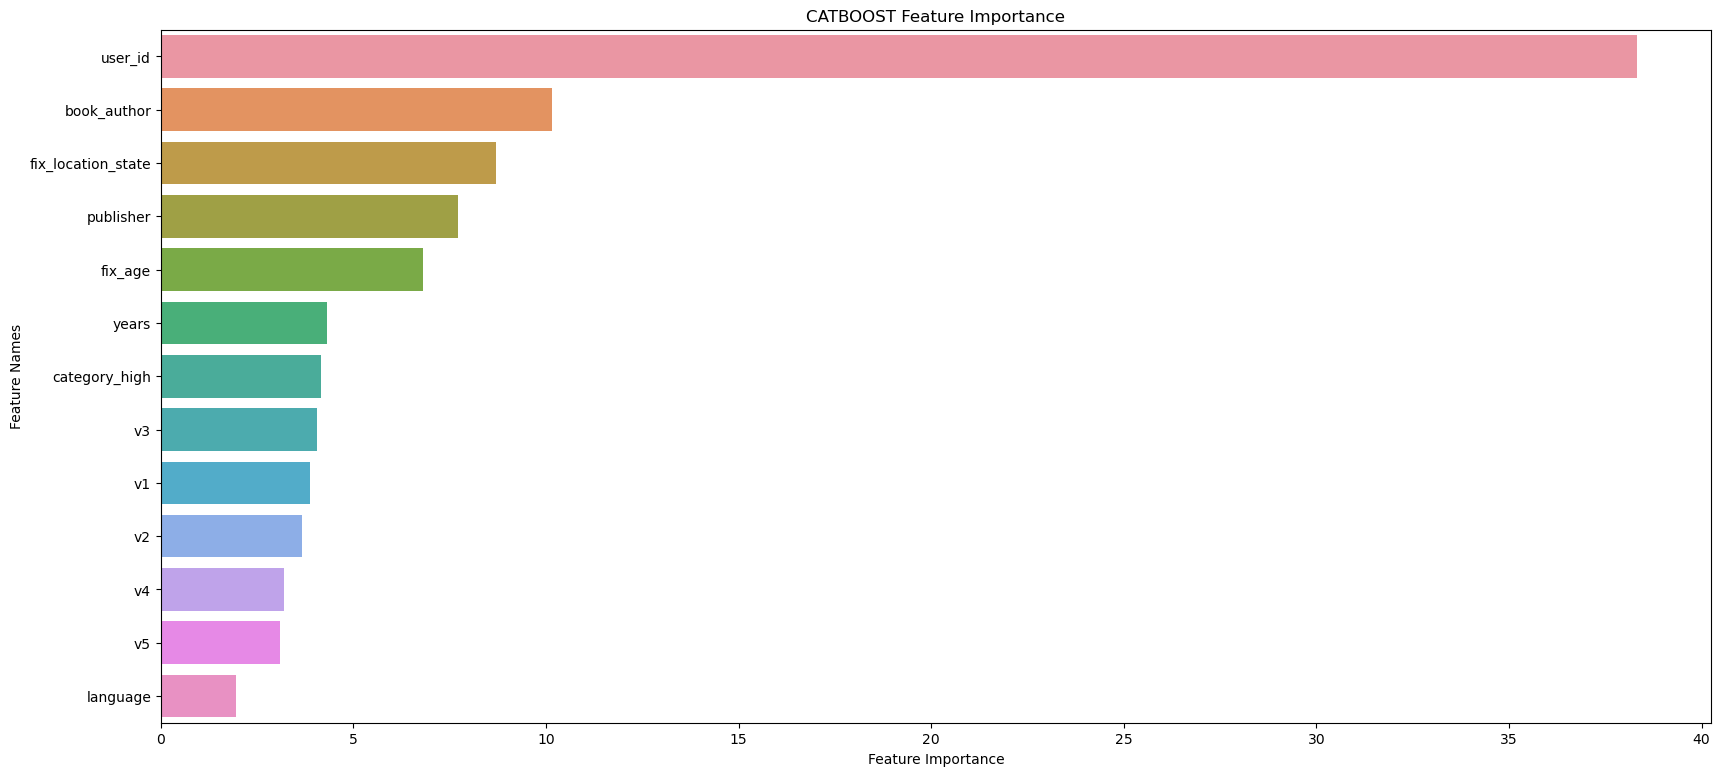

In [22]:
def plot_feature_importance(importance,names,model_type):
    
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(20,9))

    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

    plt.title(model_type + ' Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')
    
    plt.show()


plot_feature_importance(model.get_feature_importance(), train_ratings.drop(['rating'],axis = 1).columns, 'CATBOOST')